# Exercises - GEO4902-03 - Ensemble prediction
[Save google-collab as jupyter notebook or html, with your name in the filename, and upload on canvas]
 
## Exercise 1 - Forecast of a convective extreme precipitation event
Use: https://github.com/franzihe/GEO4902_2021/blob/main/03/Ensemble_Prediction_Part1.ipynb 


The script gives you a framework to assess ensemble forecasts from the Scandinavian ensemble forecasting system. All 10 ensemble members are within one forecast file.
The extreme precipitation event (Telemark, Agder, Vestfold) occurred on 13th July 2019.

![](/home/franzihe/Documents/Python/GEO4902_exercises/EX3_Fig1.png)

![](/home/franzihe/Documents/Python/GEO4902_exercises/EX3_Fig2.png)


In [1]:
# import packages
import xarray as xr
import math
import numpy as np
import cartopy as cy
from matplotlib import pyplot as plt
from cmcrameri import cm

### Load forecast
1. You can decide on an initial time you want to use to assess the ensemble forecasts. In total, use two different initial times to get an idea of predictability for this event.

In [2]:
year =  '2019'
day  =  '13'
month = '07'
hour_1  ='06'

url='https://thredds.met.no/thredds/dodsC/meps25epsarchive/' +year+'/'+month+'/'+day+'/meps_subset_2_5km_'+year+month+day+'T'+hour_1+'Z.nc'
forecast_1 = xr.open_dataset(url)

hour_2 = '12'
url='https://thredds.met.no/thredds/dodsC/meps25epsarchive/' +year+'/'+month+'/'+day+'/meps_subset_2_5km_'+year+month+day+'T'+hour_2+'Z.nc'
forecast_2 = xr.open_dataset(url)

### Plot forecast on a map

2. Plot the spatial maps of 6-hour accumulated precipitation for different ensemble members. Note, the variable in the forecast file is accumulated precipitation from the start of the forecast, so you need to “de-accumulate” the fields.



In [3]:
# de-accumulate with xarray diff
pp_6h_1 = forecast_1.precipitation_amount_acc.sel(time = forecast_1.time.dt.hour.isin([6, 12, 18, 0])).squeeze().diff('time')
pp_6h_2 = forecast_2.precipitation_amount_acc.sel(time = forecast_2.time.dt.hour.isin([6, 12, 18, 0])).squeeze().diff('time')

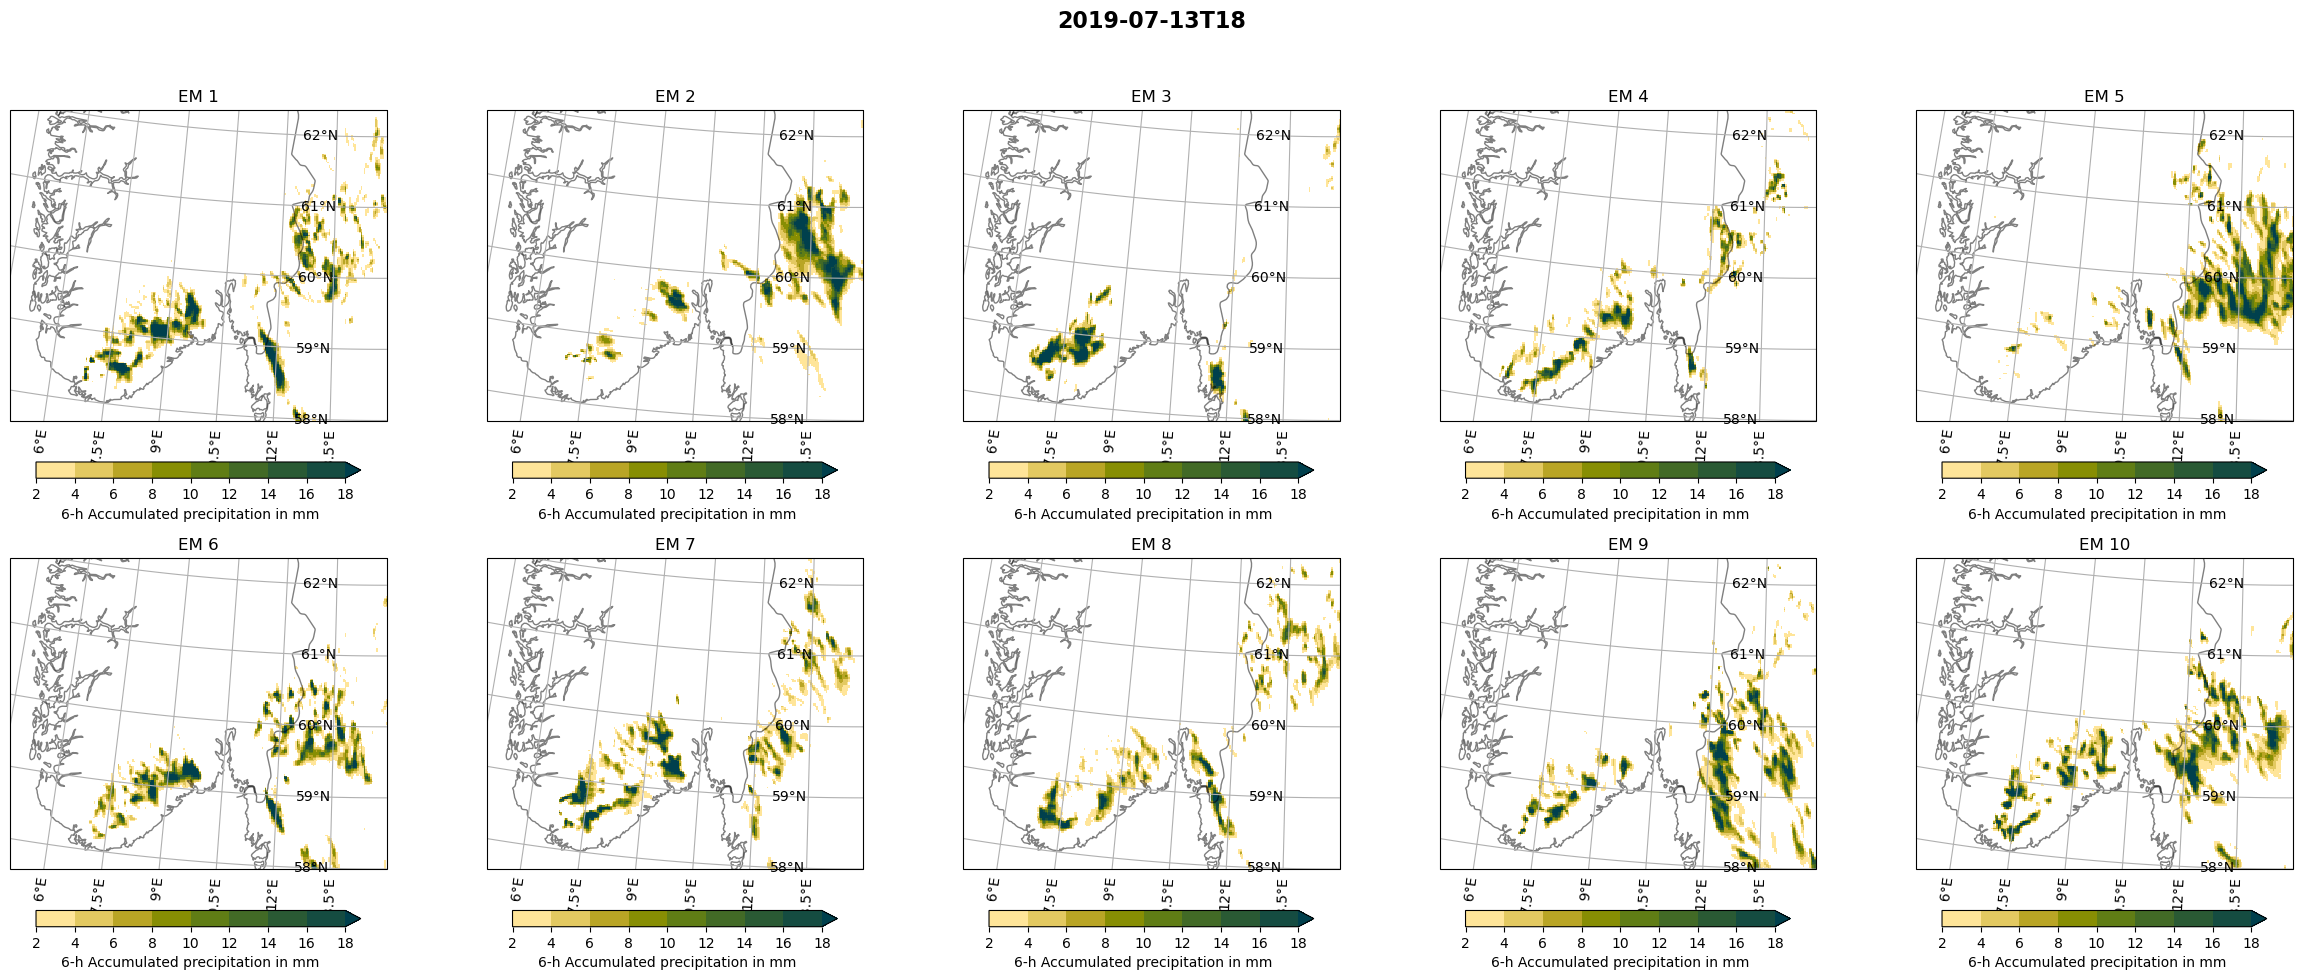

In [4]:
timestep = '2019-07-13T18:00:00.000000000'

projection = cy.crs.Stereographic(central_latitude=75, central_longitude=15.0, )
f, axsm = plt.subplots(2,5, subplot_kw={'projection':projection}, figsize=[24, 10])

for ax, em in zip(axsm.flatten(), pp_6h_1.ensemble_member.values):
    # plot cosmetics
    ax.set_extent([5, 15, 58, 62], cy.crs.PlateCarree())
    ax.add_feature(cy.feature.COASTLINE, alpha=0.5)
    ax.add_feature(cy.feature.BORDERS, alpha=0.5)
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels=False
    gl.right_labels=True
    
    pp_6h_1.sel(time = timestep, ensemble_member = em).plot.pcolormesh(ax=ax, 
                                                                       x='longitude', 
                                                                       y='latitude',
                                                                       cmap=cm.bamako_r,
                                                                       extend='max',
                                                                       levels=np.arange(2,20,2),
                                                                       transform=cy.crs.PlateCarree(),
                                                                       cbar_kwargs={'orientation':'horizontal','label':'6-h Accumulated precipitation in mm', 'shrink':0.7, 'pad':0.1})
    ax.title.set_text('EM {}'.format(str(forecast_1.ensemble_member.sel(ensemble_member = em).values+1)))

plt.tight_layout()
f.subplots_adjust(top=0.88)
f.suptitle(np.datetime_as_string(forecast_1.time.sel(time = timestep),unit='h'),fontsize=16, fontweight="bold");

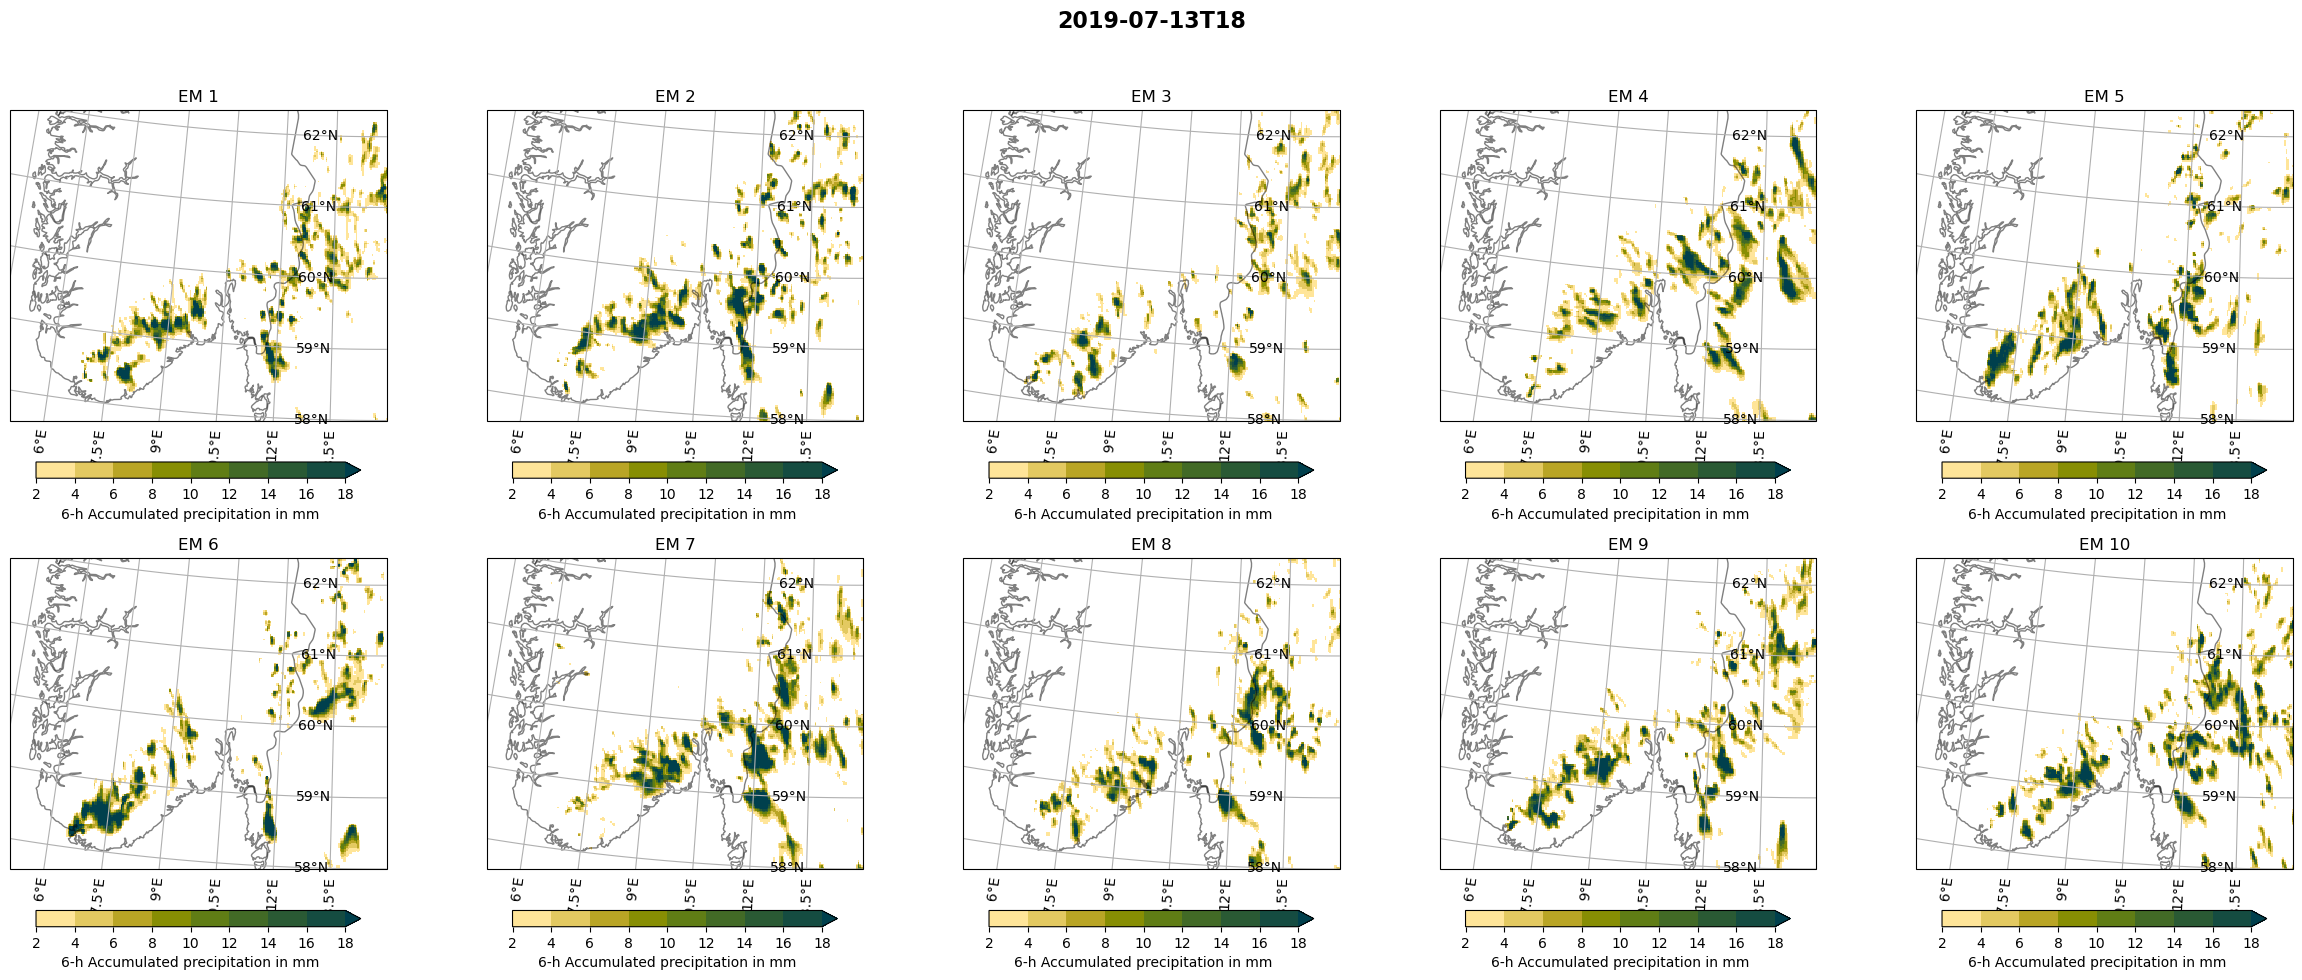

In [5]:
f, axsm = plt.subplots(2,5, subplot_kw={'projection':projection}, figsize=[24, 10])

for ax, em in zip(axsm.flatten(), pp_6h_2.ensemble_member.values):
    # plot cosmetics
    ax.set_extent([5, 15, 58, 62], cy.crs.PlateCarree())
    ax.add_feature(cy.feature.COASTLINE, alpha=0.5)
    ax.add_feature(cy.feature.BORDERS, alpha=0.5)
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels=False
    gl.right_labels=True
    
    pp_6h_2.sel(time = timestep, ensemble_member = em).plot.pcolormesh(ax=ax, 
                                                                       x='longitude', 
                                                                       y='latitude',
                                                                       cmap=cm.bamako_r,
                                                                       extend='max',
                                                                       levels=np.arange(2,20,2),
                                                                       transform=cy.crs.PlateCarree(),
                                                                       cbar_kwargs={'orientation':'horizontal','label':'6-h Accumulated precipitation in mm', 'shrink':0.7, 'pad':0.1})
    ax.title.set_text('EM {}'.format(str(forecast_2.ensemble_member.sel(ensemble_member = em).values+1)))

plt.tight_layout()
f.subplots_adjust(top=0.88)
f.suptitle(np.datetime_as_string(forecast_2.time.sel(time = timestep),unit='h'),fontsize=16, fontweight="bold");

3. You will note differences between all the 10 ensemble members. Do you have ideas on how to derive forecast products that combine the information of the 10 ensemble members but still give information about the severity (i.e., the extreme) of the forecasted weather situation?


In [6]:
# ensemble mean of 6-hour precipitation accumulation
pp_6h_mean = pp_6h_1.mean(dim = 'ensemble_member')

# ensemble spread of 6-hour precipitation accumulation
pp_6h_var = pp_6h_1.var(dim= 'ensemble_member')
pp_6h_spread = np.sqrt(pp_6h_var.mean(dim = 'time'))#

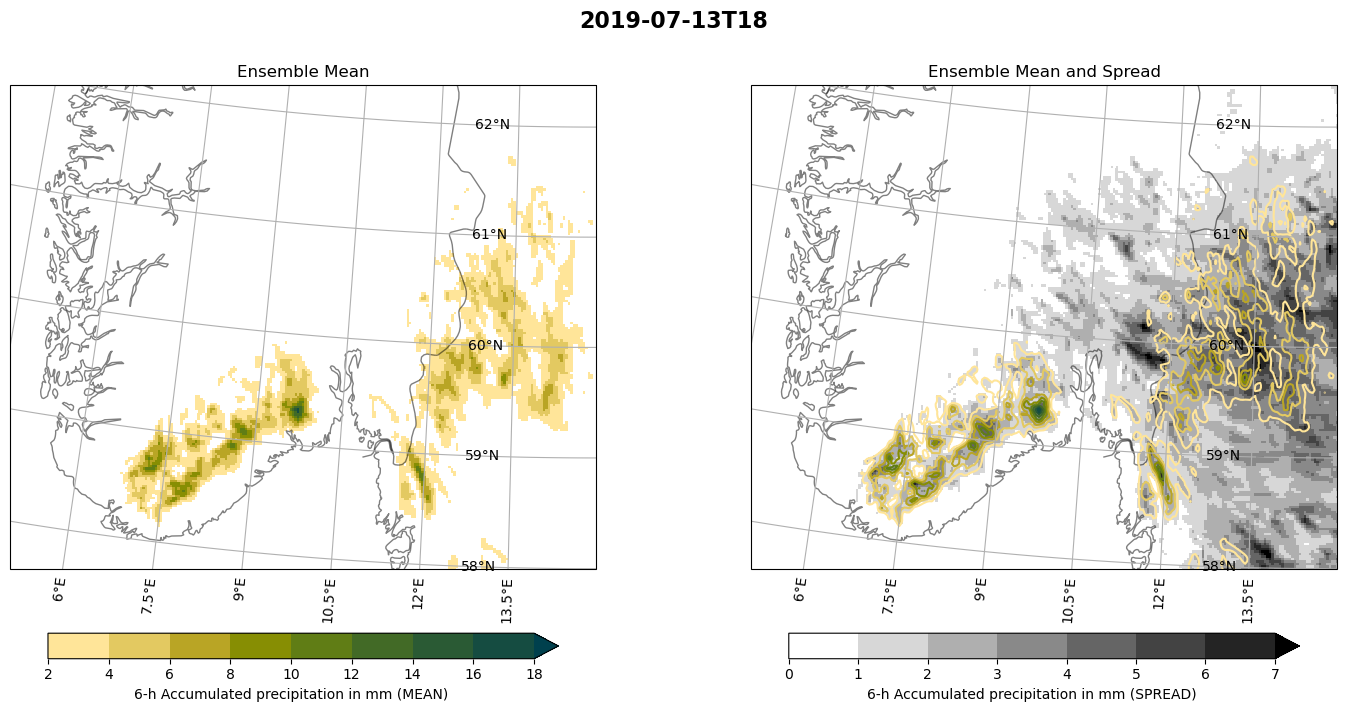

In [7]:
# plot the ensemble mean and standard deviation (spread) as spatial map
# from pyproj import transform


timestep = '2019-07-13T18:00:00.000000000'

f, axsm = plt.subplots(1,2, subplot_kw={'projection':projection}, figsize=[15, 7.5])

for ax in axsm.flatten():
    # plot cosmetics
    ax.set_extent([5, 15, 58, 62], cy.crs.PlateCarree())
    ax.add_feature(cy.feature.COASTLINE, alpha=0.5)
    ax.add_feature(cy.feature.BORDERS, alpha=0.5)
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels=False
    gl.right_labels=True

axs = axsm.flatten()
# PLOT (1) ensemble mean
pp_6h_mean.sel(time = timestep).plot.pcolormesh(ax=axs[0], 
                                             x='longitude', 
                                             y='latitude',
                                             cmap=cm.bamako_r,
                                             add_colorbar=True,
                                             extend='max',
                                             levels=np.arange(2,20,2),
                                             transform=cy.crs.PlateCarree(),
                                             cbar_kwargs={'orientation':'horizontal','label':'6-h Accumulated precipitation in mm (MEAN)', 
                                                          'shrink':0.7, 'pad':0.1})
axs[0].title.set_text('Ensemble Mean')


# PLOT (2) ensemble mean + spread to give information about the severeness of the forecast
# spread
pp_6h_spread.plot.pcolormesh(ax=axs[1],
                           x='longitude',
                           y='latitude',
                           cmap=cm.grayC,
                           add_colorbar=True,
                           extend='max', 
                           levels=np.arange(0,8),
                           transform=cy.crs.PlateCarree(),
                           cbar_kwargs={'orientation':'horizontal','label':'6-h Accumulated precipitation in mm (SPREAD)', 
                                        'shrink':0.7, 'pad':0.1})
# mean
pp_6h_mean.sel(time = timestep).plot.contour(ax=axs[1], 
                                             x='longitude', 
                                             y='latitude',
                                             cmap=cm.bamako_r,
                                             add_colorbar=False,
                                             extend='max',
                                             levels=np.arange(2,20,2),
                                             transform=cy.crs.PlateCarree(),
                                             )

axs[1].title.set_text('Ensemble Mean and Spread')

plt.tight_layout()
f.subplots_adjust(top=0.88)
f.suptitle(np.datetime_as_string(pp_6h_mean.time.sel(time = timestep),unit='h'),fontsize=16, fontweight="bold");

In an ensemble prediction system it is not clear how large the ensemble spread should be. However, it should correspond to the uncertainty of the forecast. If we compare the forecast to observations then the observations should be within the spread of the forecast.

Small spread theoretically indicates high forecast accuracy, large spread theoretically indicates low forecast accuracy. The accuracy of the ensemble mean (EM) can be estimated by the spread of the ensemble; on average, the larger the spread, the larger the expected EM error.

Comparison between ensemble mean and spread: These charts show consistency from one forecast to the next and can help forecasters judge how far into the future the ensemble can carry informative value for large synoptic patterns. The grey shading does not indicate the probability of the location of a feature, but indicates the magnitude of the uncertainty. 

4. You can try to plot your own ensemble forecast product (from part 3) or derive a forecast plot that shows the probability of 6 hourly precipitation which exceeds a certain threshold (e.g., 20 mm per 6 hours).


In [8]:
# mean of all members where precipitation exeeds 20 mm/6h
pp_6h_20_mean = pp_6h_1.where(pp_6h_1 >= 20).mean('ensemble_member')

# probability where precipitation exeeds 20mm/6h
pp_6h_20_prob = pp_6h_1.where(pp_6h_1 >= 20).sum('ensemble_member')

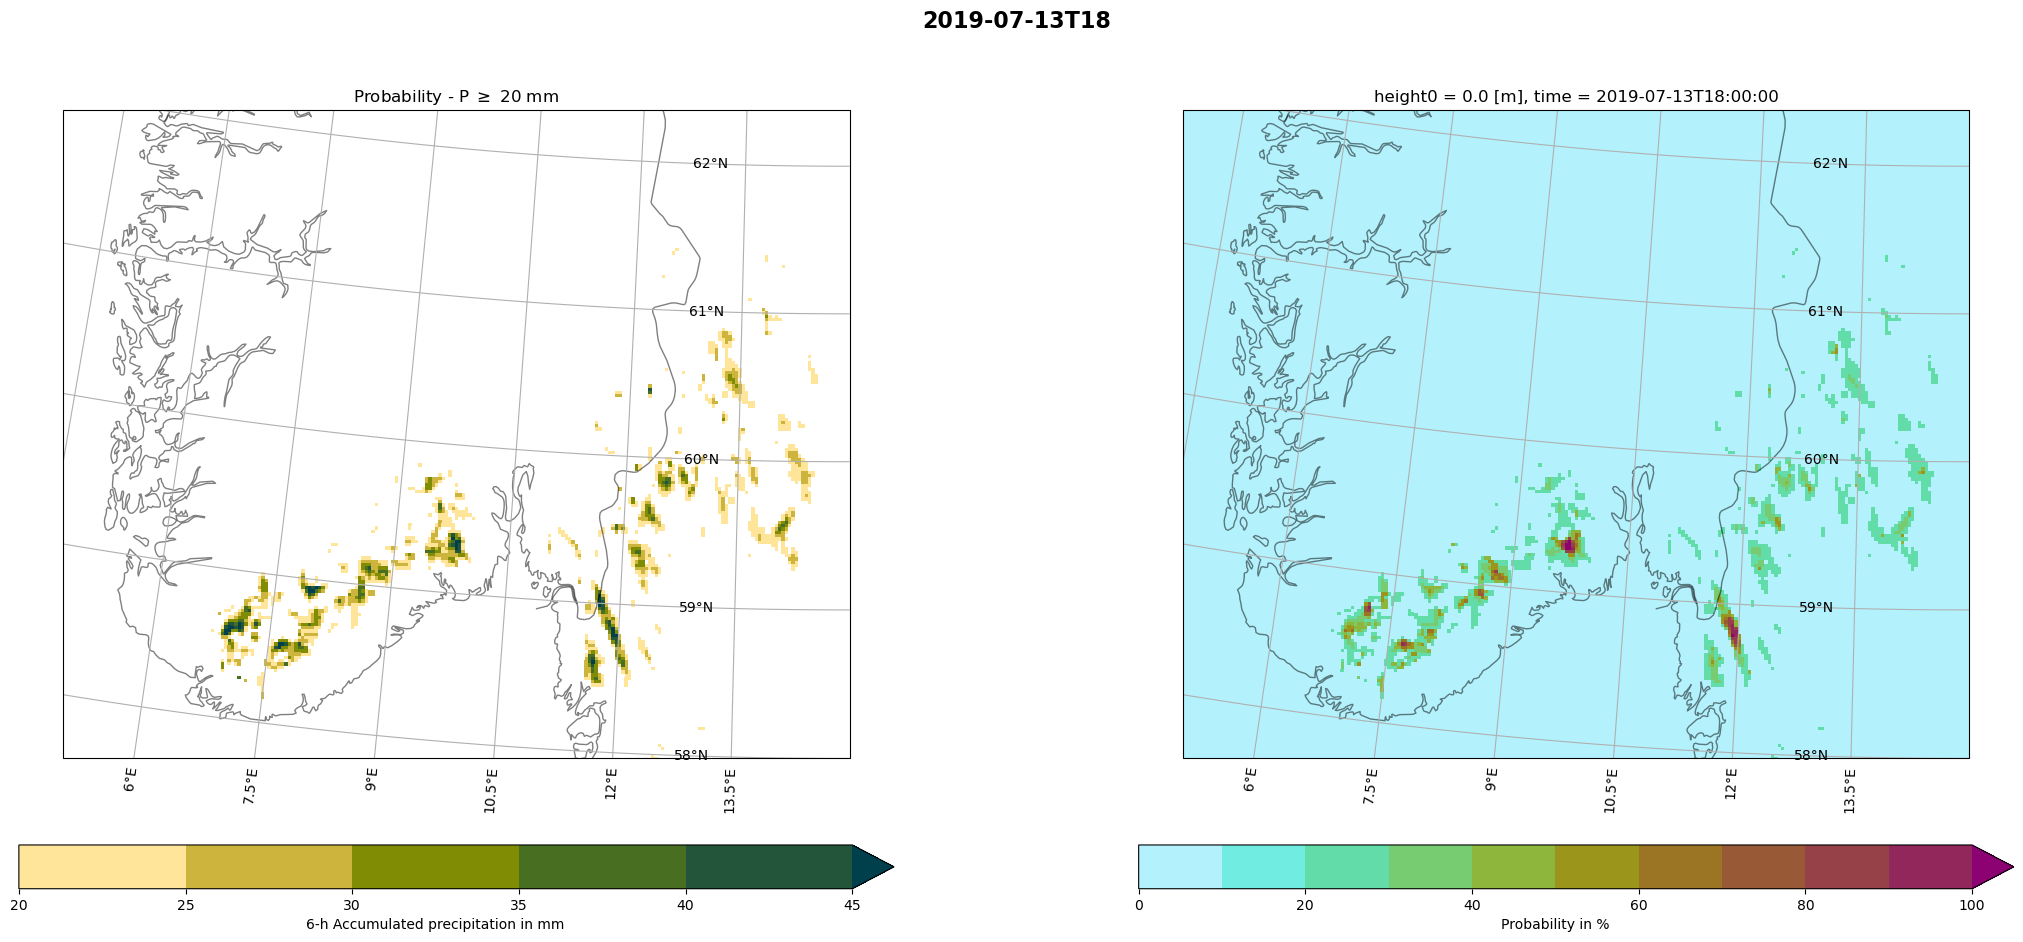

In [9]:
f, axsm = plt.subplots(1,2, subplot_kw={'projection':projection}, figsize=[24, 10])

for ax in axsm.flatten():
    # plot cosmetics
    ax.set_extent([5, 15, 58, 62], cy.crs.PlateCarree())
    ax.add_feature(cy.feature.COASTLINE, alpha=0.5)
    ax.add_feature(cy.feature.BORDERS, alpha=0.5)
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels=False
    gl.right_labels=True

axs = axsm.flatten()
# PLOT (1) ensemble mean
pp_6h_20_mean.sel(time = timestep,).plot.pcolormesh(ax=axs[0], 
                                                                       x='longitude', 
                                                                       y='latitude',
                                                                       cmap=cm.bamako_r,
                                                                       extend='max',
                                                                       levels=np.arange(20,50,5),
                                                                       transform=cy.crs.PlateCarree(),
                                                                       cbar_kwargs={'orientation':'horizontal','label':'6-h Accumulated precipitation in mm', 'shrink':0.7, 'pad':0.1})
axs[0].title.set_text('Ensemble mean - P $\geq$ 20 mm')

# PLOT (2) probability
pp_6h_20_prob.sel(time = timestep,).plot.pcolormesh(ax=axs[1], 
                                                                       x='longitude', 
                                                                       y='latitude',
                                                                       cmap=cm.hawaii_r,
                                                                       levels=np.arange(0,105,10),
                                                                       transform=cy.crs.PlateCarree(),
                                                                       cbar_kwargs={'orientation':'horizontal','label':'Probability in %', 'shrink':0.7, 'pad':0.1})
axs[0].title.set_text('Probability - P $\geq$ 20 mm')



plt.tight_layout()
f.subplots_adjust(top=0.88)
f.suptitle(np.datetime_as_string(pp_6h_20_mean.time.sel(time = timestep),unit='h'),fontsize=16, fontweight="bold");

## Exercise 2 - Forecast of a polar low 
Use: https://github.com/franzihe/GEO4902_2021/blob/main/03/Ensemble_Prediction_Part2.ipynb 


The script gives you a framework to assess ensemble forecasts from the Scandinavian ensemble forecasting system. All 10 ensemble members are within one forecast file.
The polar low occurred on 4th February 2020 at about 2 pm, as described in exercise 01.



In [10]:
year =  '2020'
day  =  '03'
month = '02'

hour_1  ='18'

url='https://thredds.met.no/thredds/dodsC/meps25epsarchive/' +year+'/'+month+'/'+day+'/meps_extracted_2_5km_'+year+month+day+'T'+hour_1+'Z.nc'
forecast_PL = xr.open_dataset(url)



1. Plot the wind speed forecasts at Tromsø for all ensemble members. What would be a good way to define a forecast product dependent on the lead time? Try to program it and plot it as an ensemble forecast product. (You can also look in the lecture notes for inspiration)

In [11]:
def findindex(alat,alon,plat,plon):
    #finding identical location of pos plat, plon in array alat[],alon[]
    abslat = np.abs(alat-plat)
    abslon = np.abs(alon-plon)
    c = np.maximum(abslon,abslat)
    y, x = np.where(c == np.min(c))
    x=int(x)
    y=int(y)
   
    return (x,y)

In [12]:
# select nearest grid point to station data
lat_tos=69.6537; lon_tos=18.9368 # Tromsø

[xloc_tos,yloc_tos] = findindex(forecast_PL.latitude,forecast_PL.longitude,lat_tos,lon_tos)

In [13]:
# show if we selected the correct lat and lon for Tromsø
print('Tromsø AROME, lat:', (forecast_PL.latitude.isel(y = yloc_tos, x = xloc_tos).values).round(2,), 'lon:', (forecast_PL.longitude.isel(y = yloc_tos, x = xloc_tos).values).round(2))


Tromsø AROME, lat: 69.67 lon: 18.92


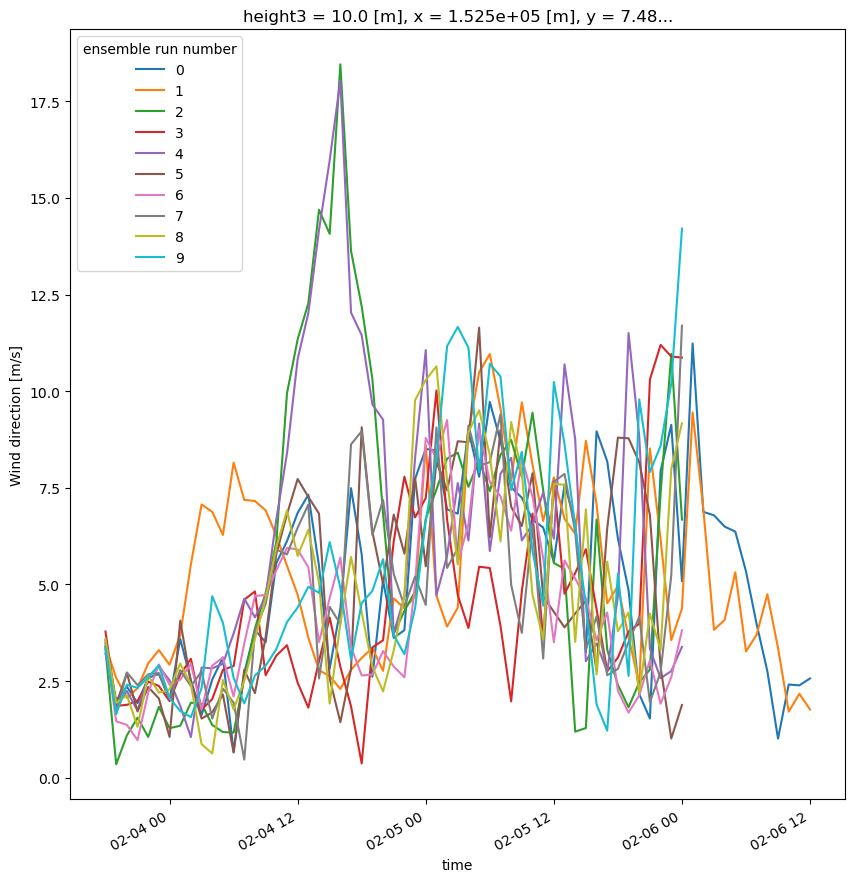

In [14]:
f, ax = plt.subplots(figsize=[10, 10])                              # define figure

(forecast_PL.wind_speed.isel(x = xloc_tos, y = yloc_tos,height3 = 0)).plot.line(ax = ax, x='time', add_legend=True);                          # plot with xarray.plot function


Because of storage issues, Met-Norway only saves ensemble member 0 and 1 hourly for 66 hours lead time. Ensemble member 2 through 9, only have values until 54 hours lead time. 

2. Plot the spread (as we defined it in the course) for the ensemble wind forecast.

In [15]:
# ensemble mean of wind speed for Tromsø
WS_mean = forecast_PL.wind_speed.isel(x = xloc_tos, y = yloc_tos,height3 = 0).mean('ensemble_member')

# ensemble spread of wind speed for Tromsø
WS_var = forecast_PL.wind_speed.isel(x= xloc_tos, y = yloc_tos, height3=0).var('ensemble_member')
WS_spread = (np.sqrt(WS_var))#.mean(dim='time')

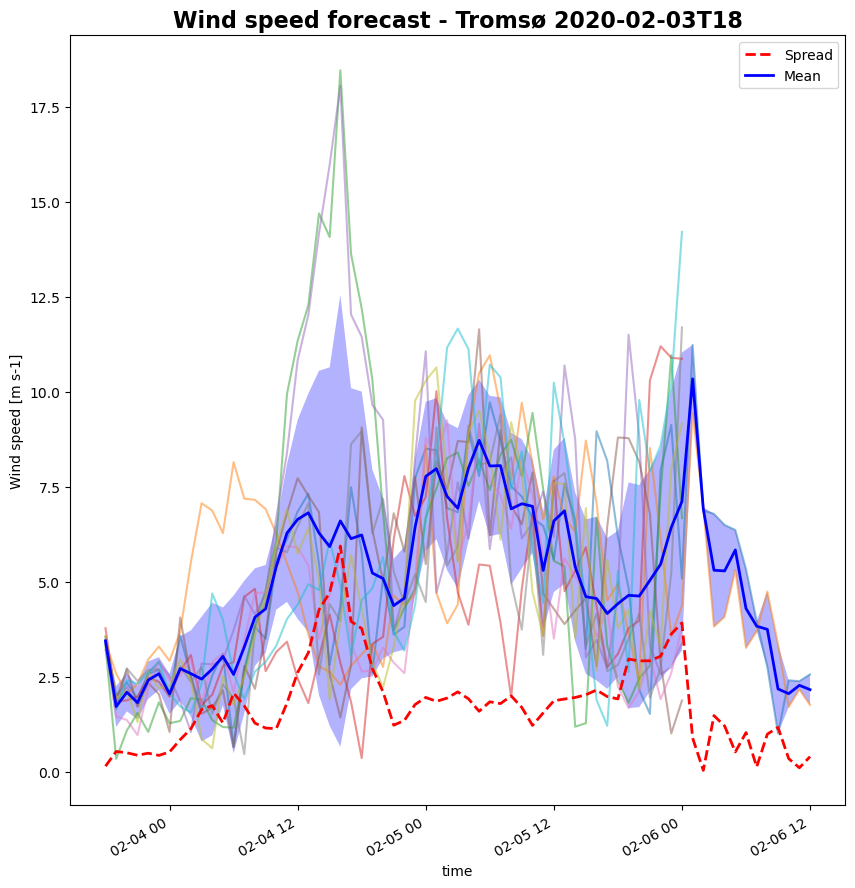

In [16]:
fig, ax = plt.subplots(1, 1, figsize=[10, 10])

# plot ensemble members
(forecast_PL.wind_speed.isel(x = xloc_tos, y = yloc_tos,height3 = 0)).plot.line(ax = ax, x='time', add_legend=True, alpha=0.5);                          # plot with xarray.plot function


# plot spread
WS_spread.plot(label='Spread', color='r', linestyle='--', linewidth=2.)


# plot mean with spread
WS_mean.plot(ax = ax, label='Mean', color='b', linewidth=2.)
ax.fill_between(forecast_PL.time, 
                WS_mean - np.fabs(WS_spread), 
                WS_mean + np.fabs(WS_spread), 
                alpha= 0.3, facecolor='b')



# plot legend
ax.legend(loc='upper right')
# title 
ax.set_title('Wind speed forecast - Tromsø {}'.format(np.datetime_as_string(forecast_PL.time.isel(time=0),unit='h')), 
             fontsize=16, fontweight='bold')
ax.set_ylabel('Wind speed [m s-1]');



3. Plot the sea level pressure map for different ensemble members. What could here be a good way of showing the position of the polar low by using the forecast information of the 10 ensemble members?


In [17]:
# sea level pressure
timestep = '2020-02-04T14:00:00.000000000'
level = 0

psfc = (forecast_PL.air_pressure_at_sea_level.sel(time = timestep, height_above_msl = level ))/100

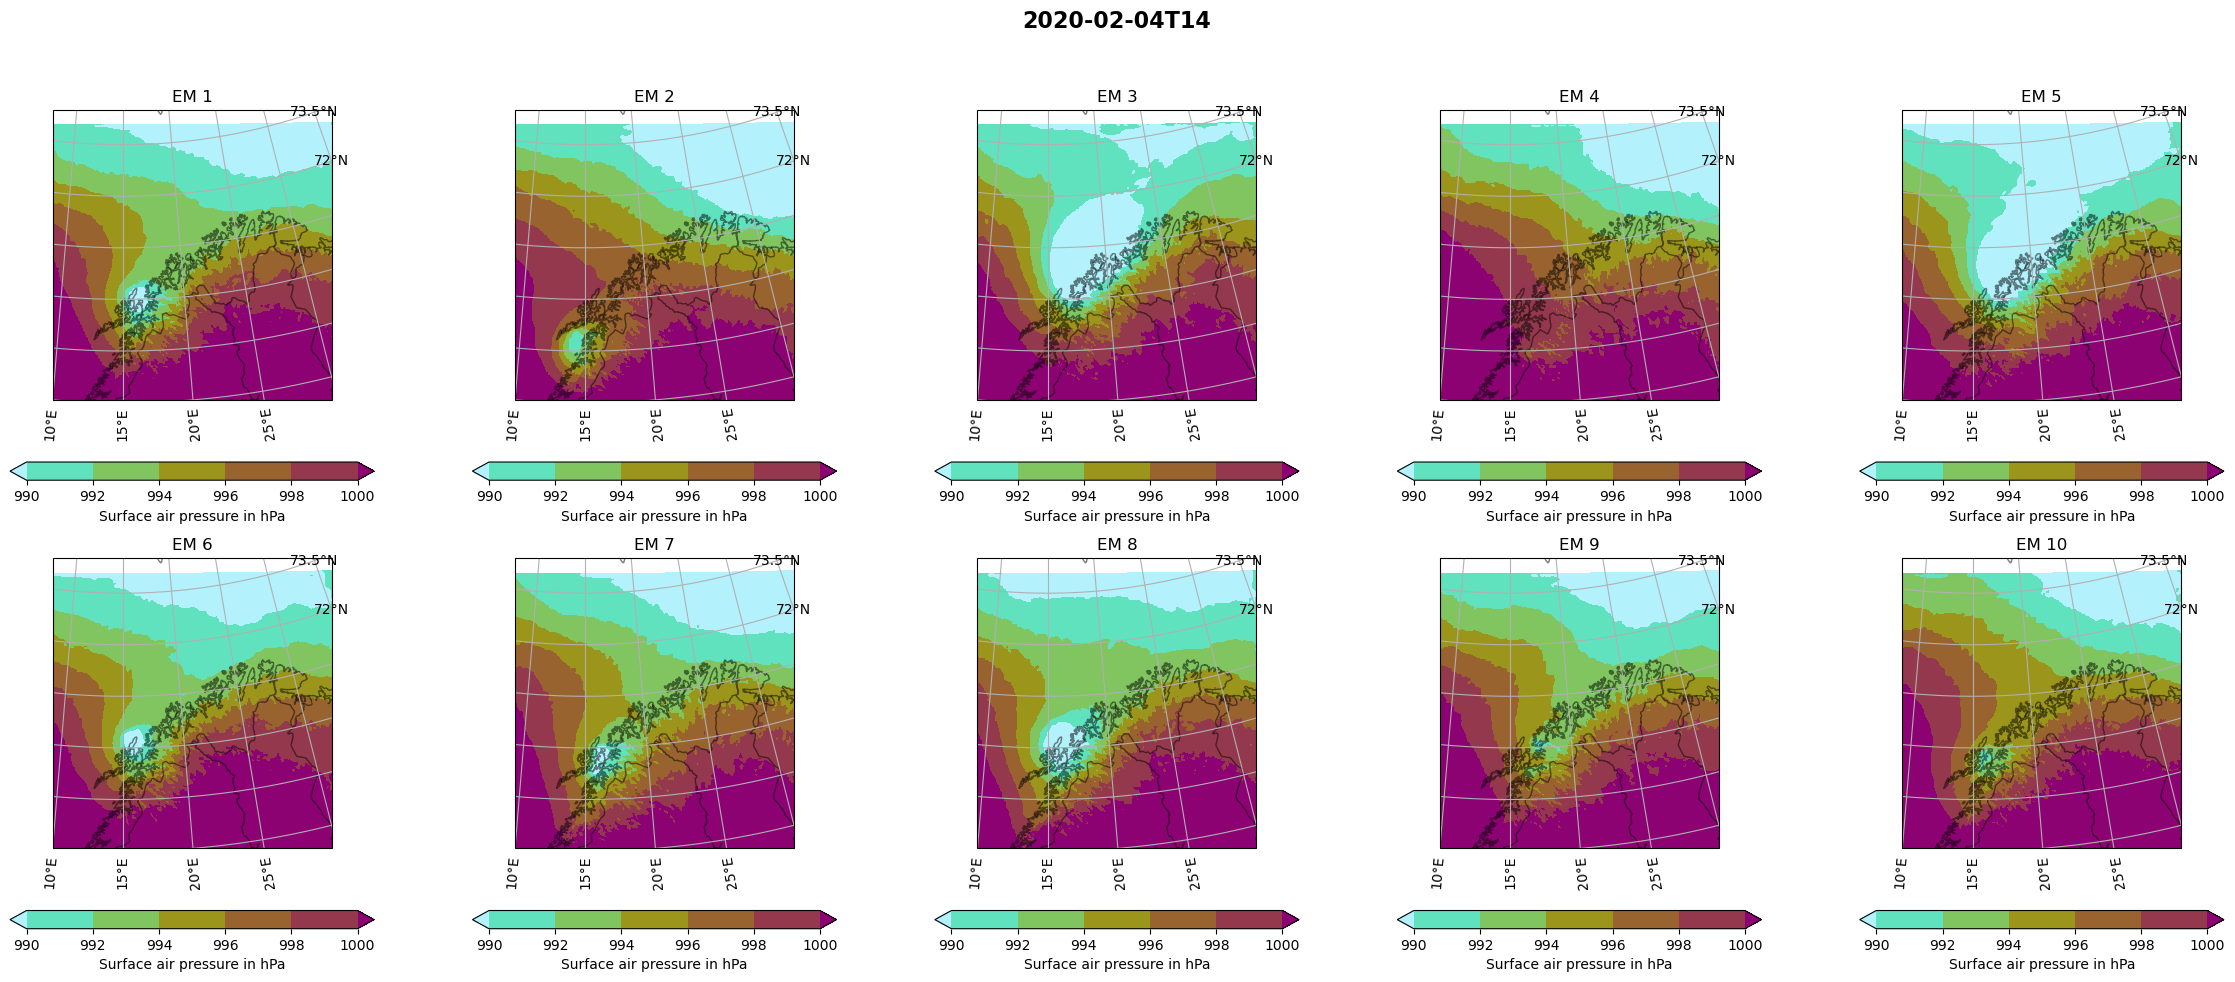

In [18]:
f, axsm = plt.subplots(2,5, subplot_kw={'projection':projection}, figsize=[24, 10])

for ax, em in zip(axsm.flatten(), psfc.ensemble_member.values):
    # plot cosmetics
    ax.set_extent([10, 30, 66, 74], cy.crs.PlateCarree())
    ax.add_feature(cy.feature.COASTLINE, alpha=0.5)
    ax.add_feature(cy.feature.BORDERS, alpha=0.5)
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels=False
    gl.right_labels=True
    
    psfc.isel(ensemble_member=em).plot.pcolormesh(ax=ax, 
                                                  x='longitude', 
                                                  y='latitude',
                                                  cmap=cm.hawaii_r,
                                                  extend='both',
                                                  levels=range(990, 1002,2),
                                                  transform=cy.crs.PlateCarree(),cbar_kwargs={'orientation':'horizontal','label':'Surface air pressure in hPa', 'shrink':0.7, 'pad':0.15})
    
    ax.title.set_text('EM {}'.format(str(forecast_PL.ensemble_member.sel(ensemble_member = em).values+1)))

plt.tight_layout()
f.subplots_adjust(top=0.88)
f.suptitle(np.datetime_as_string(forecast_PL.time.sel(time = timestep),unit='h'),fontsize=16, fontweight="bold");

In [19]:
# ensemble mean
psfc_mean = (forecast_PL.air_pressure_at_sea_level.sel(time = timestep, height_above_msl = level)/100).mean('ensemble_member')

# ensemble spread of surface air pressure
psfc_var = (forecast_PL.air_pressure_at_sea_level.sel(time = timestep,height_above_msl = level)/100).var(dim= 'ensemble_member')
psfc_spread = np.sqrt(psfc_var)

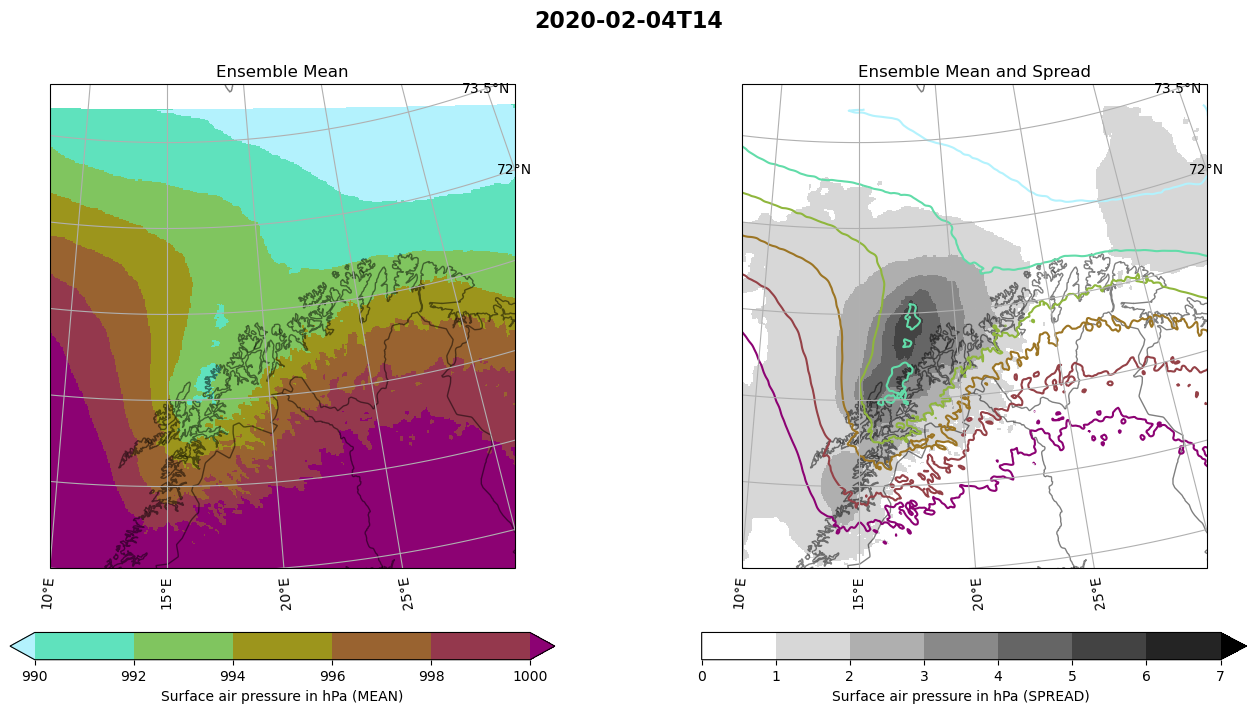

In [20]:
# plot the ensemble mean and standard deviation (spread) as spatial map

f, axsm = plt.subplots(1,2, subplot_kw={'projection':projection}, figsize=[15, 7.5])

for ax in axsm.flatten():
    # plot cosmetics
    ax.set_extent([10, 30, 66, 74], cy.crs.PlateCarree())
    ax.add_feature(cy.feature.COASTLINE, alpha=0.5)
    ax.add_feature(cy.feature.BORDERS, alpha=0.5)
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels=False
    gl.right_labels=True

axs = axsm.flatten()
# PLOT (1) ensemble mean
psfc_mean.plot.pcolormesh(ax=axs[0], 
                          x='longitude', 
                          y='latitude',
                          cmap=cm.hawaii_r,
                          extend='both',
                          levels=range(990, 1002,2),
                          transform=cy.crs.PlateCarree(),
                          cbar_kwargs={'orientation':'horizontal','label':'Surface air pressure in hPa (MEAN)', 
                                       'shrink':0.7, 'pad':0.1} 
                                                  )
axs[0].title.set_text('Ensemble Mean')


# PLOT (2) ensemble mean + spread to give information about the severeness of the forecast
# spread
psfc_spread.plot.pcolormesh(ax=axs[1],
                           x='longitude',
                           y='latitude',
                           cmap=cm.grayC,
                           extend='max', 
                           levels=np.arange(0,8),
                           transform=cy.crs.PlateCarree(),
                           cbar_kwargs={'orientation':'horizontal','label':'Surface air pressure in hPa (SPREAD)', 
                                        'shrink':0.7, 'pad':0.1})

# mean
psfc_mean.plot.contour(ax=axs[1], 
                                             x='longitude', 
                                             y='latitude',
                                             cmap=cm.hawaii_r,
                                             add_colorbar=False,
                                             extend='both',
                                             levels=range(990, 1002,2),
                                             transform=cy.crs.PlateCarree(),
                                             )

axs[1].title.set_text('Ensemble Mean and Spread')

plt.tight_layout()
f.subplots_adjust(top=0.88)
f.suptitle(np.datetime_as_string(forecast_PL.time.sel(time = timestep),unit='h'),fontsize=16, fontweight="bold");

In [21]:
from nbconvert import HTMLExporter

def output_HTML(read_file, output_file):
    import codecs
    import nbformat
    exporter = HTMLExporter()
    # read_file is '.ipynb', output_file is '.html'
    output_notebook = nbformat.read(read_file, as_version=4)
    output, resources = exporter.from_notebook_node(output_notebook)
    codecs.open(output_file, 'w', encoding='utf-8').write(output)



current_file = '03_Ensemble_Prediction.ipynb'
output_file = '03_Ensemble_Prediction.html'
output_HTML(current_file, output_file)
